In [2]:
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import scipy.interpolate as interp
import scipy.optimize as sciopt

In [3]:
ab_plate_path = '../calibration_data/calibration_08302023/EK_single_AB_constant_gain_20230830_122655.xlsx'
od_plate_path = '../calibration_data/calibration_08302023/EK_single_OD600_20230830_114542.xlsx'
p_ab = AutoRate.Plate(ab_plate_path,mode='single_measurement')
p_od = AutoRate.Plate(od_plate_path,mode='single_measurement')
od_data = p_od.od_data_to_dict(p_od.data)

In [4]:
row_list = ['A','B','C','D','E','F','G','H']
bg_cols = [1,11,12]
bg_cols = [str(c) for c in bg_cols]

bg_est = 0
indx = 0
for row in row_list:
    for col in bg_cols:
        key = row + col
        bg_est += od_data[key]
        indx+=1

bg_est = bg_est/indx

col_list = np.arange(12) + 1
col_list = [str(c) for c in col_list]

for row in row_list:
    for col in col_list:
        key = row+col
        od_data[key] = od_data[key] - bg_est

In [5]:
#%% Estimate cell count from OD
row_indx = 0

# refactor data into 2d array
od_data_t = np.zeros((len(row_list)-2,len(col_list)-2))
for row in row_list[1:-1]:
    col_indx = 0
    for col in col_list[1:-1]:
        key = row + col
        od_data_t[row_indx,col_indx] = od_data[key]
        col_indx += 1
    row_indx += 1

# calculate mean and standard error
od_avg = np.mean(od_data_t,axis=0)
od_std = np.std(od_data_t,axis=0)
od_err = od_std/np.sqrt(len(row_list)-2)

# fig,ax = plt.subplots()

# generate dilutions based on 2x dilution scheme

dilutions_str = []
dilutions = []
for i in range(len(col_list)-2):
    dilutions_str.append(str(2**i) + 'x')
    dilutions.append(1/(2**i))

dilutions[-1] = 0
dilutions_str[-1] = '0x'


def od_to_cells(od):
    """Background subtracted od to cell count

    Args:
        od (_type_): _description_

    Returns:
        _type_: _description_
    """
    m = 1
    b = 13.52
    res = []
    for o in od:
        if o < 0:
            res.append(0)
        else:
            res.append(np.exp(m*np.log(o) + b))
    return np.array(res)

cell_count = od_to_cells(od_avg) # estimated from od data
cell_count_err = od_to_cells(od_err)

cell_count_est = [d*cell_count[0] for d in dilutions] # estimated from dilution scheme
cell_count_est[-1] = 0

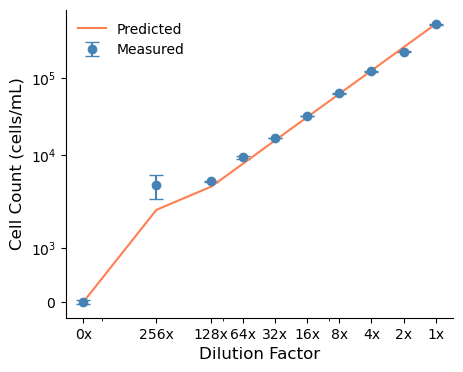

In [120]:
fig,ax = plt.subplots(figsize=(5,4))

ax.errorbar(dilutions,cell_count,yerr=cell_count_err,fmt='o',capsize=5,label='Measured',color='steelblue')
ax.plot(dilutions,cell_count_est,label='Predicted',color='coral')

ax.set_xscale('symlog',linthresh=10**-2.2)
ax.set_yscale('symlog',linthresh=10**3.2)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Dilution Factor',fontsize=12)
ax.set_xticks(dilutions)
ax.set_xticklabels(dilutions_str)
ax.set_ylabel('Cell Count (cells/mL)',fontsize=12)

ax.legend(frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('../../figures/od_cell_count_calibration.pdf',bbox_inches='tight')

In [7]:
# get the fluorescence data

fluor_data = p_ab.od_data_to_dict(p_ab.data)

cmap = mpl.colormaps['viridis']

# estimate background
bg_est = 0
indx = 0
for row in row_list:
    col = '11' # no cells in this column
    key = row + col
    bg_est += fluor_data[key]
    indx+=1
bg_est = bg_est/indx

fluor_data_t = np.zeros((len(row_list)-2,len(col_list)-2))
fluor_data_std = np.zeros((len(row_list)-2,len(col_list)-2))
row_indx = 0
for row in row_list[1:-1]:
    col_indx = 0
    for col in col_list[1:-1]:
        key = row + col
        fluor_data_t[row_indx,col_indx] = fluor_data[key] - bg_est
        col_indx += 1
    row_indx += 1

fluor_avg = np.mean(fluor_data_t,axis=0) # background substrated fluorescence
fluor_err = np.std(fluor_data_t,axis=0)/np.sqrt(len(row_list)-2)

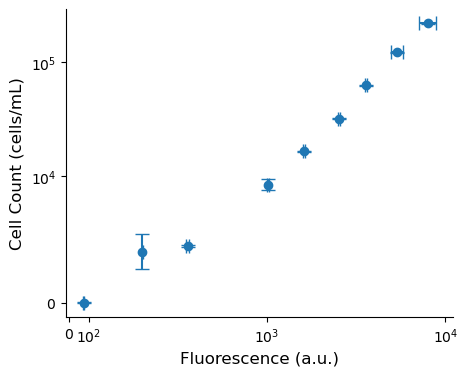

In [26]:
fig,ax = plt.subplots(figsize=(5,4))

# the first data point the optical density obscures the fluorescence
ax.errorbar(fluor_avg[1:],cell_count[1:],xerr=fluor_err[1:],yerr=cell_count_err[1:],fmt='o',capsize=5)

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_yscale('symlog',linthresh=10**4)
ax.set_xscale('symlog',linthresh=10**3)

ax.set_xlabel('Fluorescence (a.u.)',fontsize=12)
ax.set_ylabel('Cell Count (cells/mL)',fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('../../figures/fluor_vs_cell_count.pdf',bbox_inches='tight')

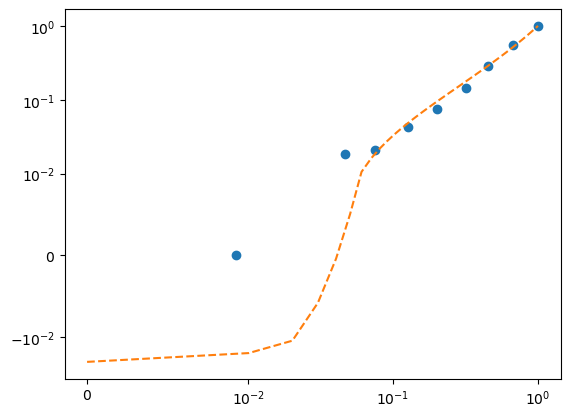

In [9]:
def expon(x,a,r,k):
    return a*np.exp(r*x) - k

cell_count_norm = cell_count[1:]/cell_count[1]
fluor_norm = fluor_avg[1:]/fluor_avg[1]

popt,pcov = sciopt.curve_fit(expon,fluor_norm,cell_count_norm)

x = np.linspace(0,1,100)
y = expon(x,*popt)

fig,ax = plt.subplots()

ax.plot(fluor_norm,cell_count_norm,'o')
ax.plot(x,y,'--')
ax.set_yscale('symlog',linthresh=10**-2)
ax.set_xscale('symlog',linthresh=10**-2)
# ax.set_xlabel('Fluorescence (a.u.)')

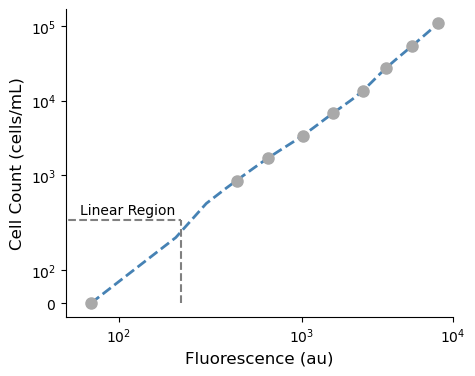

In [94]:
s = 0
k = 2

# sort data
sort_indx = np.argsort(fluor_norm)
fluor_norm = fluor_norm[sort_indx]
# cell_count_norm = cell_count_norm[sort_indx]
cell_count_norm = np.flip(np.array(dilutions[1:]))
cell_count_norm = cell_count_norm[sort_indx]

spline = interp.UnivariateSpline(fluor_norm,cell_count_norm,k=k,s=s)
xfit = np.linspace(np.min(fluor_norm),np.max(fluor_norm),100)
yfit = spline(xfit)

# fig,ax = plt.subplots(figsize=(5,4))

# ax.plot(xfit,yfit,'--',color='steelblue',label='Spline Fit',linewidth=2)
# ax.plot(fluor_norm,cell_count_norm,'o',color='darkgrey',markersize=8,label='Data')

# # ax.set_yscale('symlog',linthresh=10**-2)
# ax.set_xscale('symlog',linthresh=10**-2)
# ax.set_xlabel('Normalized Fluorescence',fontsize=12)
# ax.set_ylabel('Normalized Cell Count',fontsize=12)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

fig,ax = plt.subplots(figsize=(5,4))

ax.plot(xfit*fluor_avg[1],yfit*cell_count[1],'--',color='steelblue',label='Spline Fit',linewidth=2)
ax.plot(fluor_norm*fluor_avg[1],cell_count_norm*cell_count[1],'o',color='darkgrey',markersize=8,label='Data')

# ax.set_yscale('symlog',linthresh=10**-2)

ythresh = 10**2.4
xthresh = 10**2.2

ax.set_xscale('symlog',linthresh=xthresh)
# ax.set_xscale('log')
ax.set_yscale('symlog',linthresh=ythresh)

ax.set_xlim([50,10**4])

# put lines at the symlog thresholds

ax.plot([xthresh,xthresh],[0,ythresh],'--',color='grey')
ax.plot([0,xthresh],[ythresh,ythresh],'--',color='grey')

# add annotation for linear region

ax.annotate('Linear Region',xy=(xthresh/2.5,ythresh*1.2))

ax.set_xlabel('Fluorescence (au)',fontsize=12)
ax.set_ylabel('Cell Count (cells/mL)',fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('../../figures/fluor_vs_cell_count_spline_fit.pdf',bbox_inches='tight')

In [11]:
def rfu30_to_cell_count(rfu30,background_subtracted=True):
    """Convert RFU30 to cell count

    Args:
        rfu30 (float): RFU30 value
        background_subtracted (bool, optional): If the RFU30 value is background subtracted. Defaults to True.

    Returns:
        float: cell count
    """
    if background_subtracted == False:
        rfu30 = rfu30 - bg_est
    rfu30_norm = rfu30/fluor_avg[1]
    return spline(rfu30_norm)*cell_count[1]

In [12]:
fluor_avg + bg_est

array([3909.66666667, 8232.66666667, 5623.33333333, 3852.83333333,
       2774.16666667, 1856.83333333, 1258.16666667,  844.66666667,
        616.        ,  319.5       ])